In [1]:
# %load gan.py
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
from IPython.display import clear_output

In [3]:
os.makedirs("images", exist_ok=True)

In [2]:
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 28
channels = 1
sample_interval = 400

In [3]:
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [5]:
# ----------
#  Training
# ----------
from IPython.display import clear_output

G_loss_history = []
D_loss_history = []

for epoch in range(n_epochs):
    G_batch_loss = 0
    D_batch_loss = 0
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        G_batch_loss += g_loss.item()
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        D_batch_loss += d_loss.item()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
    n = len(dataloader)
    G_loss_history.append(G_batch_loss / n)
    D_loss_history.append(D_batch_loss / n)
    if epoch % 10 == 0:
        clear_output()

[Epoch 191/200] [Batch 0/938] [D loss: 0.139019] [G loss: 2.866380]
[Epoch 191/200] [Batch 1/938] [D loss: 0.190455] [G loss: 2.198005]
[Epoch 191/200] [Batch 2/938] [D loss: 0.109358] [G loss: 3.422503]
[Epoch 191/200] [Batch 3/938] [D loss: 0.136904] [G loss: 3.732164]
[Epoch 191/200] [Batch 4/938] [D loss: 0.187744] [G loss: 2.532466]
[Epoch 191/200] [Batch 5/938] [D loss: 0.183018] [G loss: 3.963804]
[Epoch 191/200] [Batch 6/938] [D loss: 0.117757] [G loss: 2.904303]
[Epoch 191/200] [Batch 7/938] [D loss: 0.239284] [G loss: 2.320766]
[Epoch 191/200] [Batch 8/938] [D loss: 0.229647] [G loss: 2.762589]
[Epoch 191/200] [Batch 9/938] [D loss: 0.274770] [G loss: 3.299976]
[Epoch 191/200] [Batch 10/938] [D loss: 0.169501] [G loss: 3.274127]
[Epoch 191/200] [Batch 11/938] [D loss: 0.234152] [G loss: 1.898824]
[Epoch 191/200] [Batch 12/938] [D loss: 0.219154] [G loss: 4.528310]
[Epoch 191/200] [Batch 13/938] [D loss: 0.259332] [G loss: 2.673600]
[Epoch 191/200] [Batch 14/938] [D loss: 0.28

In [4]:
generator.load_state_dict(torch.load('gan_generator.pt'))

<All keys matched successfully>

# 用train好的generator產生64張圖片

產生64個100維的latent space

In [9]:
pic_num = 64
latent_space = np.random.normal(0, 1, (pic_num, latent_dim))

將圖片轉成(H,W,C)並畫出來

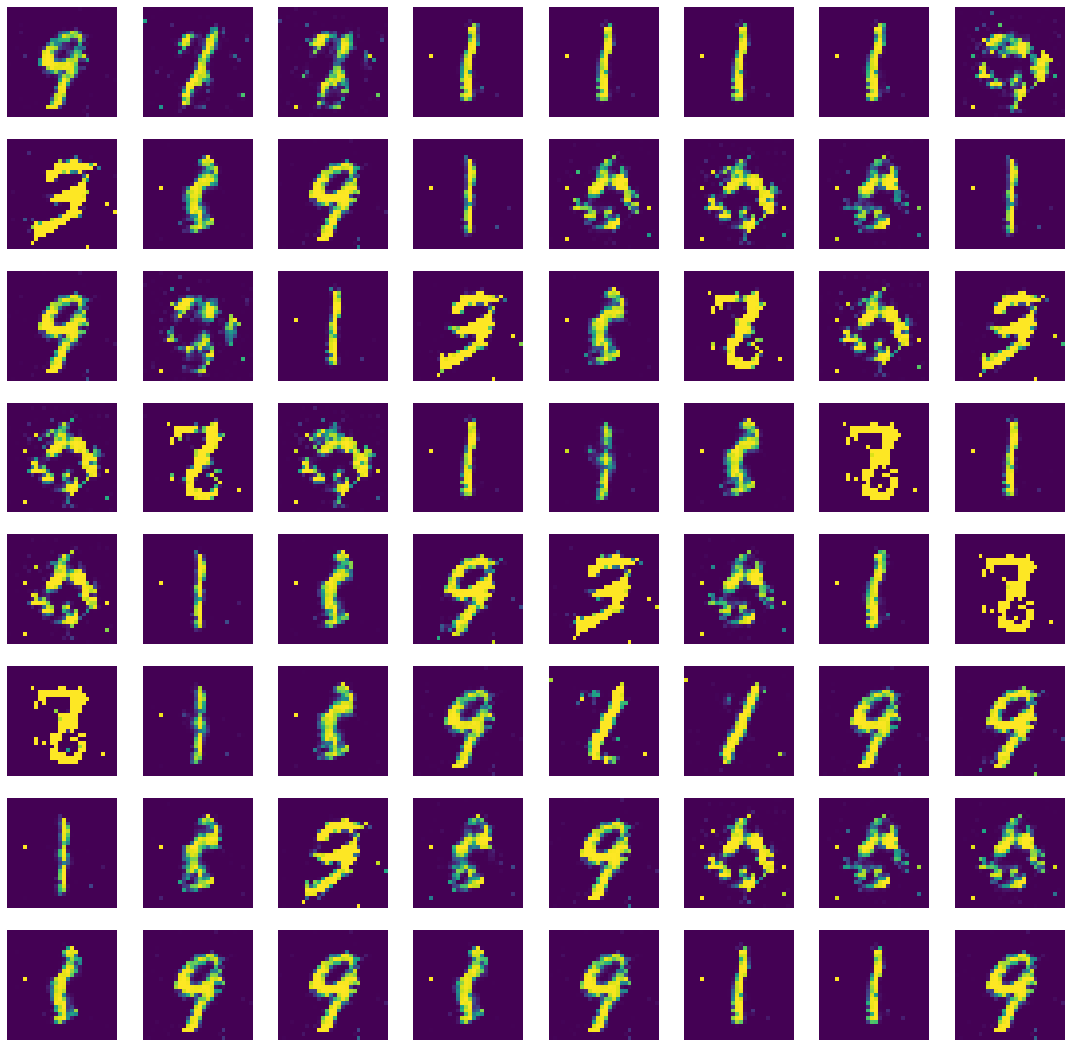

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(19, 19))
for i in range(pic_num):
    plt.subplot(8,8,i+1)
    plt.imshow(generator(Variable(Tensor(latent_space))).detach().view(pic_num, 28, 28, 1)[i].to('cpu'))
    plt.axis('off')

# 畫出Loss

Generator loss:

Text(0.5, 0, 'epochs')

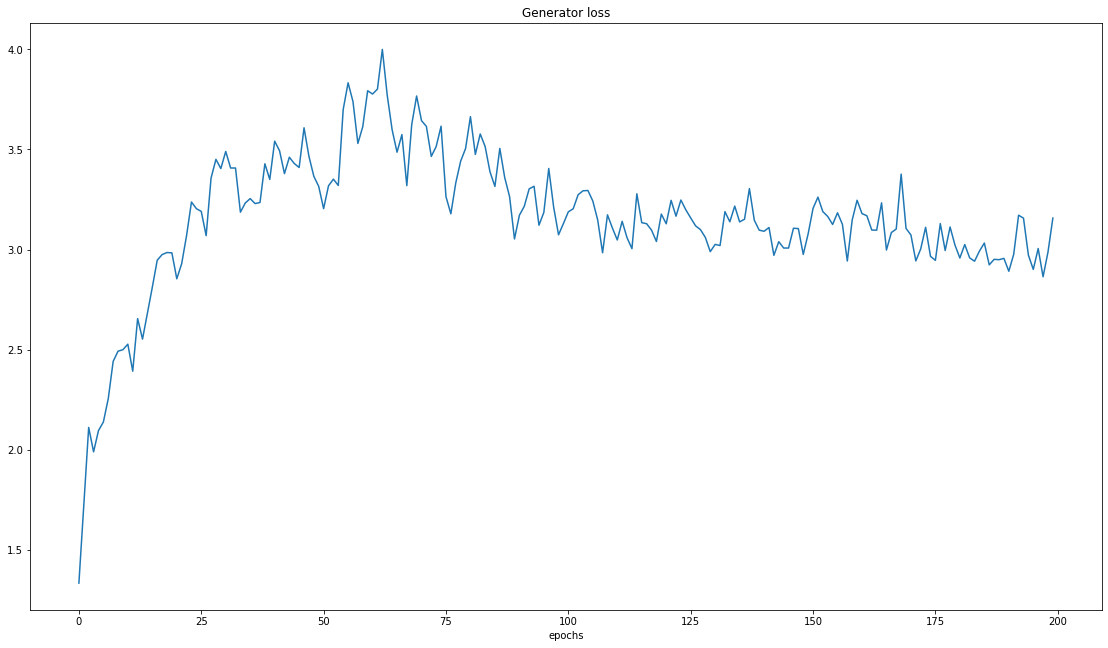

In [61]:
plt.figure(figsize=(19.2, 10.8))
plt.title('Generator loss')
x = np.arange(len(G_loss_history))
plt.plot(x, G_loss_history)
plt.xlabel('epochs')

Discriminator loss

Text(0.5, 0, 'epochs')

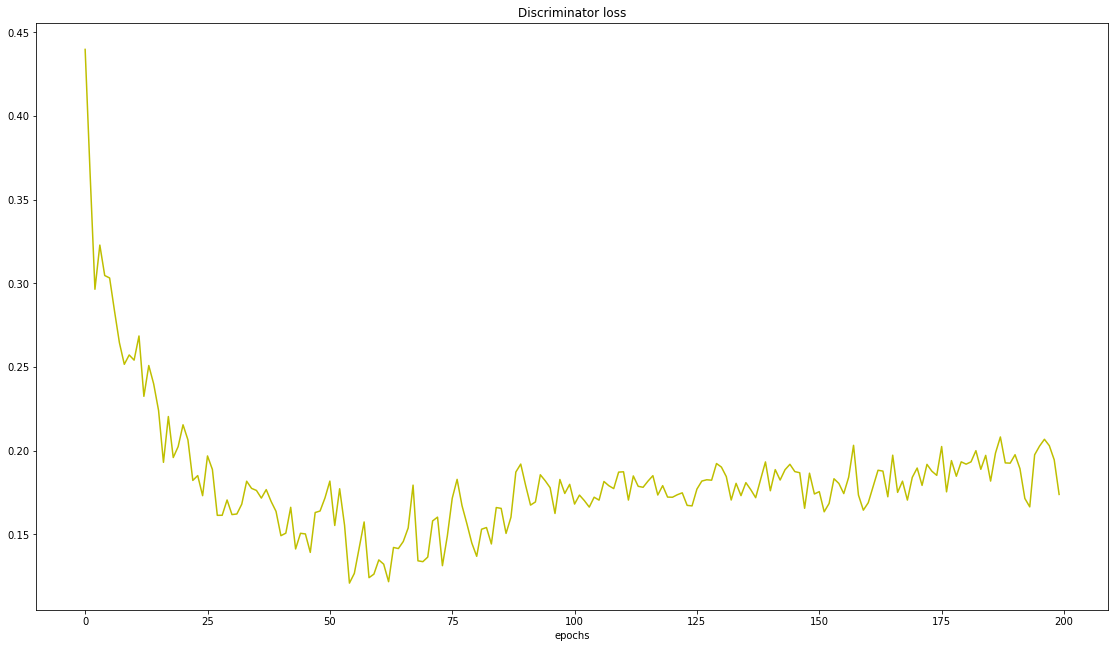

In [60]:
plt.figure(figsize=(19.2, 10.8))
plt.title('Discriminator loss')
x = np.arange(len(D_loss_history))
plt.plot(x, D_loss_history, 'y')
plt.xlabel('epochs')

In [15]:
torch.save(generator.state_dict(),'gan_generator.pt')
torch.save(discriminator.state_dict(), 'gan_discriminator.pt')

# 將tensor轉成圖片

將dataloader的batch設成1(預設就是1)，方便一張一張轉成png

In [49]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    shuffle=False,
)

將圖片存到指定路徑並依數字命名

In [51]:
n = 0
for i, _ in dataloader:
    save_image(i[0], 'mnist_images/%d.png' % n)
    n+=1

將generator產生的圖片存到指定路徑

In [5]:
pic_num = 50000
latent_space = torch.randn([pic_num, latent_dim], device='cuda')

In [6]:
generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [7]:
with torch.no_grad():
    out = generator(latent_space)

In [8]:
from PIL import Image

In [9]:
imgs = np.clip(out.cpu().numpy() * 127.5 + 127.5, 0, 255).astype(np.uint8)

In [15]:
n = 0
for i in range(pic_num):
    Image.fromarray(imgs[i,0], mode='L').save('gan_images/%d.png' % n)
    n+=1

# 計算兩組圖片之間的FID距離(越接近0代表兩者的分佈越接近，也就是圖片越像真實的圖片)

兩組data分別為mnist的60000張圖片與generator產生的50000張圖片

In [16]:
!python -m pytorch_fid --batch-size=64 --device=cuda:0 /home/ystsai/work/DeepLearning/lab5/mnist_images/ /home/ystsai/work/DeepLearning/lab5/gan_images/

100%|█████████████████████████████████████████| 782/782 [00:47<00:00, 16.61it/s]
FID:  153.43182585860933


---

# Report:

原始的gan是用minmax遊戲的概念來進行對抗，這種對抗方式正好與縮小JS divergence有關係，不過JS divergence有一些缺點，<br>
導致大部份的時候JS並不能精準的表示兩個機率分佈的差異大小。從gan生成的圖片就可以看出，某幾張圖出現的重複行很高。<br><br>
wgan是採用wasserstein distance來計算兩個機率分佈的差異，它相對於JS比較平滑一點，不過是採用clip的方式(就是maxnorm<br>
和minnorm)，並不是真正符合lipschitz連續。<br><br>
wgan_div和wgan_gp則是改進wasserstein distance實做的方式，可以看出有巨幅的改進，不過div和gp差異並不大。